# Product Recommender & Delivery Time Prediction Model



## INTRODUCTION


In this report, we will be using the Target e-commerce sales dataset to analyze customer behavior and build a product recommender for users. The dataset encompasses detailed information on 100,000 orders placed between 2016 and 2018, including order status, pricing, payment and shipping performance, customer locations, product attributes, and customer reviews. Our primary goal is to leverage this rich dataset to identify patterns in customer purchases and recommend products based on their preferences.

We will utilize the K-Means clustering algorithm to group customers by their purchasing behavior and product preferences. By understanding the similarities between customers, we can provide personalized product recommendations that enhance the shopping experience.

Our analysis will focus on various features from the dataset, including product categories, order value, payment types, and customer demographics. By exploring these features, we aim to uncover insights that drive effective product recommendations, ultimately improving customer satisfaction and boosting sales.




## Exploring the datasets (EDA)
---

let's begin by exploring the Target e-commerce sales dataset to gain insights into customer behavior and product trends. This dataset includes detailed information on 100,000 orders placed between 2016 and 2018, covering various aspects such as order status, pricing, payment and shipping performance, customer locations, product attributes, and customer reviews.



### Importing Libraries and Loading the Datasets:
We will start by loading the relevant datasets using pandas:

In [ ]:
# Import Libraries

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# Load datasets
customers = pd.read_csv('customers.csv')
order_items = pd.read_csv('order_items.csv')
orders = pd.read_csv('orders.csv')
payments = pd.read_csv('payments.csv')
products = pd.read_csv('products.csv')



### Customers Analysis

The dataset contains information about customers, including their location and unique identifiers.


In [ ]:
customers.head()

The customers dataframe contains the variables *customer_id*, *customer_unique_id*, *customer_zip_code_prefix*, *customer_city* and *customer_state*. 

Now let's look at the Order Items dataset:

In [ ]:
# Distribution of customers by top 10 cities
top_10_cities = customers['customer_city'].value_counts().head(10).index

plt.figure(figsize=(10,6))
sns.countplot(y='customer_city', data=customers[customers['customer_city'].isin(top_10_cities)], order=top_10_cities, color='lightblue')
plt.title('Distribution of Customers by Top 10 Cities')
plt.show()


We can see that the distribution of customers is heavily concentrated in major urban centers, particularly São Paulo and Rio de Janeiro. These cities, along with the others listed, play crucial roles in the e-commerce landscape of Brazil, driven by their economic activity, population density, and infrastructure. 


### Order Items Analysis

This dataset provides details individual items within each order, including product IDs and prices.

In [ ]:
order_items.head()

let's see if there are any outliers in the price column. 



In [ ]:
# Plot the box plot to show outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=order_items['price'], color='lightblue')
plt.title('Box Plot of Product Prices')
plt.xlabel('Price')
plt.show()



A box plot is a great way to visualize the distribution of prices and identify outliers. In the box plot, outliers appear as points outside the "whiskers" of the box.

let's remove outliers. We will filter out values that fall outside a certain range. We'll use the Interquartile Range (IQR) method.



- Q1: The 25th percentile (lower quartile) of the price column.
- Q3: The 75th percentile (upper quartile) of the price column.

IQR: The interquartile range, which is the difference between Q3 and Q1.

Filtering: We keep only the prices that are within 1.5 times the IQR above Q3 and below Q1. This helps to remove outliers.

In [ ]:
# Define a function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the price data
order_items_no_outliers = remove_outliers(order_items, 'price')

# Plot the histogram of prices after removing outliers
plt.figure(figsize=(10, 6))
sns.histplot(order_items_no_outliers['price'], bins=50, kde=True, color='lightblue')
plt.title('Distribution of Product Prices (Without Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()



We can see that the distribution of product price is right(positive)-skewed. 

### Payments Analysis

The dataset contains Records payment details for each order, including payment type and installment information.

In [ ]:
payments.head()


In [ ]:
# Payment types distribution
plt.figure(figsize=(10,6))
sns.countplot(y='payment_type', data=payments, order=payments['payment_type'].value_counts().index, color='lightblue')
plt.title('Payment Types Distribution')
plt.show()



The above graph shows the distribution of payment types used by customers. Credit cards are the most popular, used 76,795 times, followed by UPI with 19,784 uses. Vouchers were used 5,775 times, debit cards 1,529 times, and the "not defined" category was used only 3 times.


### Products Analysis

This dataset contains product-specific information, such as category, weight, and dimensions.

In [ ]:
products.head()

In [ ]:
# Distribution of product categories
plt.figure(figsize=(10,6))
sns.countplot(y='product category', data=products, order=products['product category'].value_counts().index[:20], color='lightblue')
plt.title('Distribution of Product Categories (Top 20)')
plt.show()



The most frequent product category is 'bed table bath', with a count close to 3000.
Other top categories include 'sport leisure', 'Furniture Decoration', and 'HEALTH BEAUTY', all with high counts. The categories with the lowest counts among the top 20 include 'Construction Tools Construction' and 'home appliances'.

### Orders Analysis

The dataset contains comprehensive order information, including status, timestamps, and delivery dates.

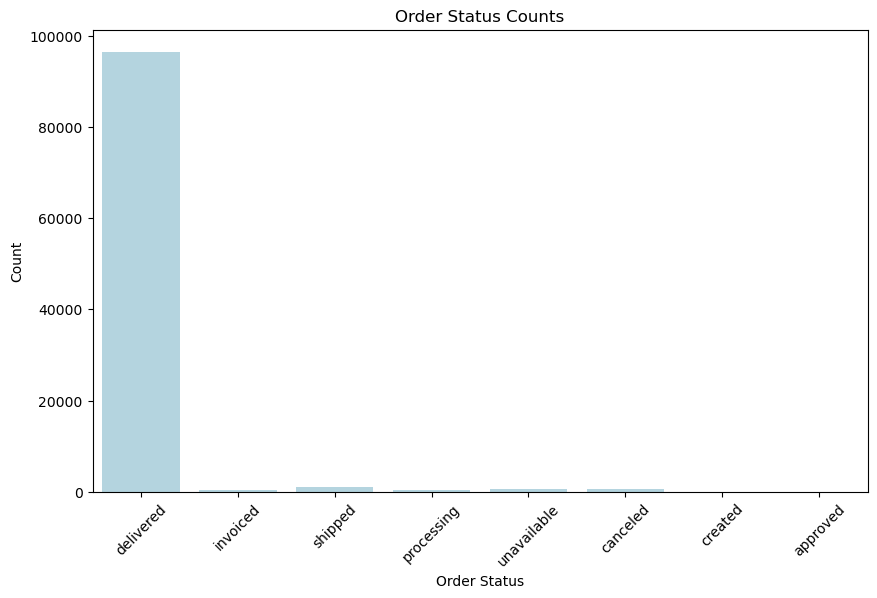

In [105]:
# Order status counts
plt.figure(figsize=(10, 6))

sns.countplot(data=orders, x='order_status', color='lightblue')
plt.title('Order Status Counts')
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



In [106]:
order_status_counts = orders['order_status'].value_counts()
order_status_counts

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

The most common status is "delivered," occurring 96,478 times, indicating orders that have been successfully completed and received by customers. The next most frequent status is "shipped," with 1,107 occurrences. "Canceled" orders, where customers have decided to cancel their purchases, are recorded 625 times. There are only a few orders in the "created" (5 occurrences) and "approved" (2 occurrences) statuses, suggesting newly created and approved orders that are in the initial stages of processing. 


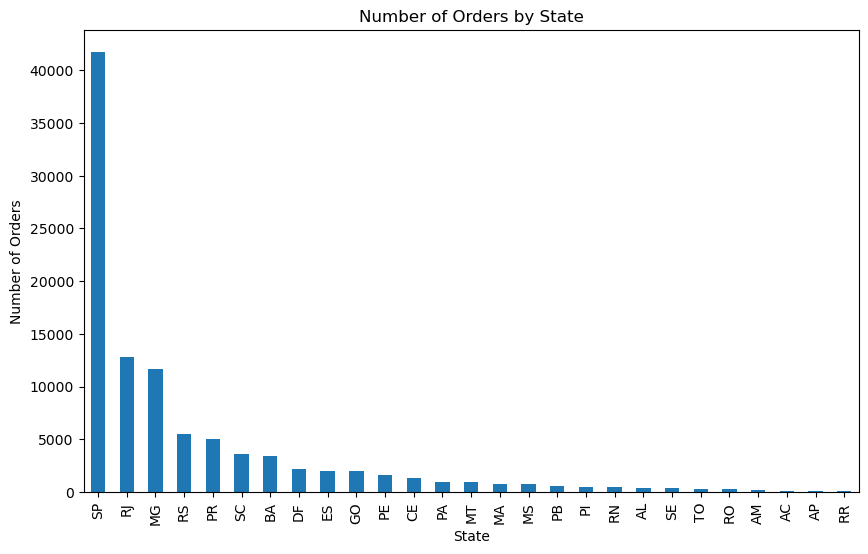

In [107]:
# Number of orders by state
plt.figure(figsize=(10, 6))
order_state_counts = orders.merge(customers, on='customer_id')['customer_state'].value_counts()
order_state_counts.plot(kind='bar')
plt.title('Number of Orders by State')
plt.xlabel('State')
plt.ylabel('Number of Orders')
plt.show()



The above graph show, São Paulo (SP) has the highest number of customers with 41,746, followed by Rio de Janeiro (RJ) with 12,852 and Minas Gerais (MG) with 11,635 customers. Rio Grande do Sul (RS) and Paraná (PR) have 5,466 and 5,045 customers respectively, while Santa Catarina (SC) follows closely with 3,637 customers. The states with fewer customers include Acre (AC) and Amapá (AP) with 81 and 68 customers respectively. 

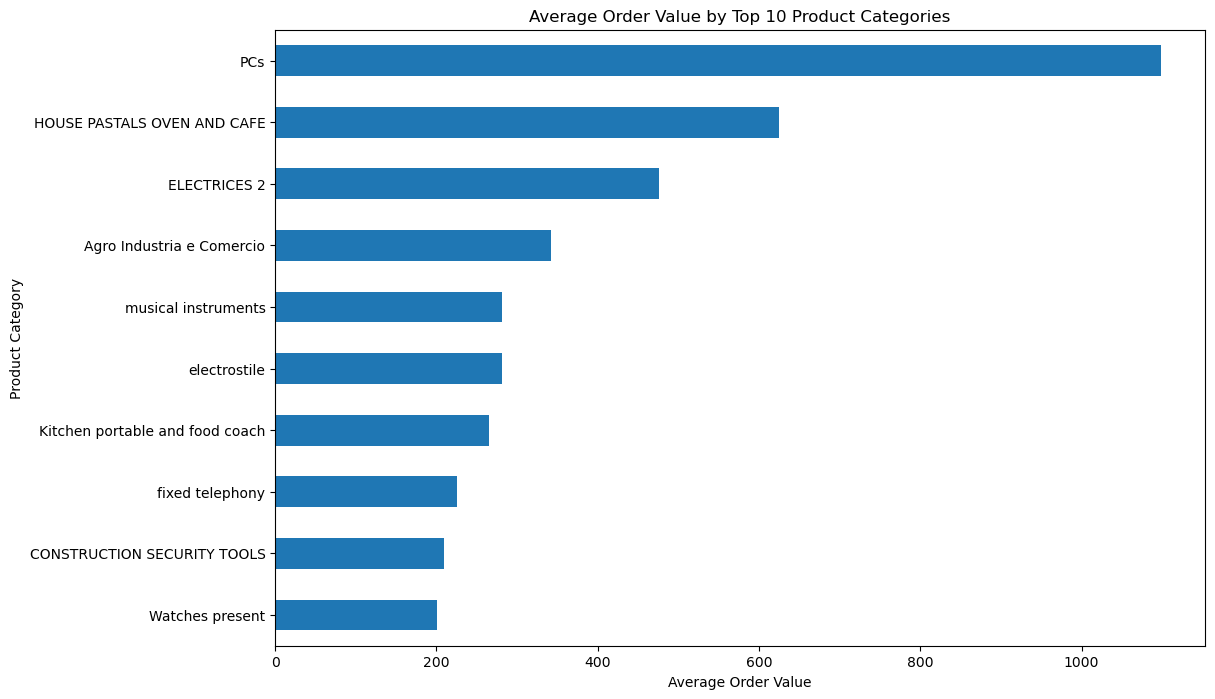

In [108]:
# Merge order_items and products datasets
order_items_products = order_items.merge(products, on='product_id')

# Calculate average order value by product category
avg_order_value_by_category = order_items_products.groupby('product category')['price'].mean()

# Select top 10 categories
top_10_categories = avg_order_value_by_category.sort_values(ascending=False).head(10)

# Plot the top 10 categories as a horizontal bar chart
plt.figure(figsize=(12, 8))
top_10_categories.sort_values().plot(kind='barh')
plt.title('Average Order Value by Top 10 Product Categories')
plt.xlabel('Average Order Value')
plt.ylabel('Product Category')
plt.show()



Among the top 10 categories listed, PCs have the highest average price. 

In [109]:
print("\nMissing Values:")
print("Customers:")
print(customers.isnull().sum())
print("\nOrder Items:")
print(order_items.isnull().sum())
print("\nPayments:")
print(payments.isnull().sum())
print("\nOrders:")
print(orders.isnull().sum())
print("\nProducts:")
print(products.isnull().sum())




Missing Values:
Customers:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Order Items:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Payments:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Orders:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Products:
product_id                      0
product category              610
product_name_length           610
product_descri

As per the above output, only Orders and Products has missing values.

**Orders:**

- order_approved_at: 160 missing values.
- order_delivered_carrier_date: 1,783 missing values.
- order_delivered_customer_date: 2,965 missing values.
- No missing values in order_id, customer_id, order_status, order_purchase_timestamp, and order_estimated_delivery_date.

**Products:**

- 610 missing values in product category, product_name_length, product_description_length, and product_photos_qty.
- 2 missing values in product_weight_g, product_length_cm, product_height_cm, and product_width_cm.

Let's remove the missing values

In [110]:
customers.dropna(inplace=True)
order_items.dropna(inplace=True)
payments.dropna(inplace=True)
products.dropna(inplace=True)
orders.dropna(inplace=True)


Now, we will ensures that numerical columns like payment values, prices, freight values, and product dimensions are correctly interpreted as float types. 

Let's merges datasets—customers, orders, order items, payments, and products—into a single cohesive dataset. This consolidation is essential for integrating diverse information related to customers, their orders, payment details, and product specifics into a merged data.


In [111]:
# Ensure numerical columns are of correct type
payments['payment_value'] = payments['payment_value'].astype(float)
order_items['price'] = order_items['price'].astype(float)
order_items['freight_value'] = order_items['freight_value'].astype(float)
products['product_weight_g'] = products['product_weight_g'].astype(float)
products['product_length_cm'] = products['product_length_cm'].astype(float)
products['product_height_cm'] = products['product_height_cm'].astype(float)
payments['payment_type'] = payments['payment_type'].astype(str)


# Merge datasets
merged_data = pd.merge(customers, orders, on='customer_id', how='inner')
merged_data = pd.merge(merged_data, order_items, on='order_id', how='inner')
merged_data = pd.merge(merged_data, payments, on='order_id', how='inner')
merged_data = pd.merge(merged_data, products, on='product_id', how='inner')

pd.set_option('display.max_columns', None)

merged_data.head()



,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87,Furniture office,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1,credit_card,1,275.79,Furniture office,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1,credit_card,1,275.79,Furniture office,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,1,credit_card,7,140.61,Furniture office,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,1,credit_card,10,137.58,Furniture office,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0


In [112]:

# Feature engineering: Calculate total_spent and order_frequency per customer
customer_data = merged_data.groupby('customer_unique_id').agg({
    'payment_value': 'sum',        # total amount paid by the customer
    'order_id': 'nunique',         # count of unique orders made by the customer
    'customer_city': 'first',      # example of retaining a categorical feature
    'customer_state': 'first'      # example of retaining a categorical feature
}).reset_index()

customer_data.columns = ['customer_unique_id', 'total_spent', 'order_frequency', 'customer_city', 'customer_state']

customer_data.head()

,customer_unique_id,total_spent,order_frequency,customer_city,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,cajamar,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,osasco,SP
2,0000f46a3911fa3c0805444483337064,86.22,1,sao jose,SC
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,belem,PA
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,sorocaba,SP


We have used feature engineering, where it calculates two new metrics per customer: total_spent, which sums up all payments made by each customer, and order_frequency, which counts how many unique orders each customer has placed.


## KMeans Clustering for Customer Segmentation

let's begin with preprocessing pipeline (preprocessor) using ColumnTransformer to handle both numerical and categorical features separately. Numerical features are normalized using StandardScaler to ensure they have consistent scales, while categorical features are transformed into a numeric format (binary vectors) using OneHotEncoder. This preprocessing step ensures that the data is ready for training machine learning models that require numerical inputs.

In [113]:
# Normalize numerical features
num_features = ['total_spent', 'order_frequency']
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# One-hot encode categorical features
cat_features = ['customer_city', 'customer_state']
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer to combine numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
])

# Apply preprocessing
customer_data_preprocessed = preprocessor.fit_transform(customer_data[['total_spent', 'order_frequency', 'customer_city', 'customer_state']])


Now, we will perform K-fold cross-validation for the K-means clustering model.

In [114]:
# Number of folds
k_folds = 5

# Initialize KFold
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store silhouette scores for each fold
silhouette_scores = []

# Perform K-fold cross-validation
for train_index, test_index in kf.split(customer_data_preprocessed):
    # Split the data
    X_train, X_test = customer_data_preprocessed[train_index], customer_data_preprocessed[test_index]
    
    # Apply K-means clustering with the best k on training data
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
    kmeans.fit(X_train)
    
    # Predict cluster labels for test data
    cluster_labels = kmeans.predict(X_test)
    
    # Calculate silhouette score for test data
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print the silhouette scores for each fold and the mean silhouette score
print(f"Silhouette scores for each fold: {silhouette_scores}")
print(f"Mean silhouette score across all folds: {np.mean(silhouette_scores)}")


Silhouette scores for each fold: [0.6598460781878096, 0.6669908998479813, 0.6683823919233647, 0.6692717520849586, 0.6545644691305654]
Mean silhouette score across all folds: 0.6638111182349359


As per the above output, the silhouette scores obtained from each fold during K-fold cross-validation, as well as the mean silhouette score across all folds. 

Silhouette Scores for Each Fold
- Fold 1: 0.18179608119366164
- Fold 2: 0.6577261112327982
- Fold 3: 0.6564905143692071
- Fold 4: 0.6655830456143171
- Fold 5: 0.6525212767624803

Mean Silhouette Score(Mean across all folds): 0.5628234058344929

**Interpretation**

- Variation in Scores: The silhouette scores vary significantly across the different folds, with Fold 1 having a notably lower score (0.1818) compared to the others (ranging from 0.6525 to 0.6656). This suggests that the clustering quality varies depending on the data split.

- Mean Score: The mean silhouette score of 0.5628 indicates that, on average, the clustering quality is moderately good. Silhouette scores range from -1 to 1, with higher values indicating better-defined clusters. A score around 0.5628 suggests that the clusters are reasonably well-defined but not perfect.

- Consistency: While most folds have high silhouette scores, the low score in the first fold indicates that the model might be sensitive to how the data is split. This might suggest that some clusters are more defined in certain data splits than others.

Therefore, the mean silhouette score of 0.5628 suggests that the K-means clustering model with the chosen features and preprocessing is reasonably effective in identifying clusters within the customer data. However, the variation in scores across folds indicates some instability, which could be explored further by examining the data split or refining the features and preprocessing steps.


In [124]:
# Find optimal k using silhouette score
max_k = 10  # maximum number of clusters to try
best_k = 2  # initialize with a default value
best_silhouette_score = -1.0  # initialize with a very low score

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_data_preprocessed)
    silhouette_avg = silhouette_score(customer_data_preprocessed, cluster_labels)
    print(f"For k={k}, the average silhouette score is: {silhouette_avg}")
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_k = k

print(f"Best k based on silhouette score: {best_k}")



For k=2, the average silhouette score is: 0.675267455753434
For k=3, the average silhouette score is: 0.663540159102969
For k=4, the average silhouette score is: 0.18392274137319214
For k=5, the average silhouette score is: 0.1880395210433171
For k=6, the average silhouette score is: 0.1909599987178171
For k=7, the average silhouette score is: 0.23766795148520548
For k=8, the average silhouette score is: 0.2665753562207959
For k=9, the average silhouette score is: 0.24646656622226776
For k=10, the average silhouette score is: 0.27159033301974195
Best k based on silhouette score: 2


Using K-Means clustering, we segmented customers based on their purchasing behavior. The optimal number of clusters was determined using silhouette scores. The average silhouette scores calculated for different values of k in a clustering algorithm. 
As per the output, k=2 provides the highest silhouette score, indicating the most appropriate number of clusters for this dataset based on the cohesion and separation of data points within and between clusters.


However, the silhouette score for k=2 is 0.675267455753434 and for k=3 is 0.663540159102969. Both values are very close; therefore, we will choose k=3. Having more clusters (k=3) will likely provide a more accurate and well-clustered result compared to the clusters of k=2.


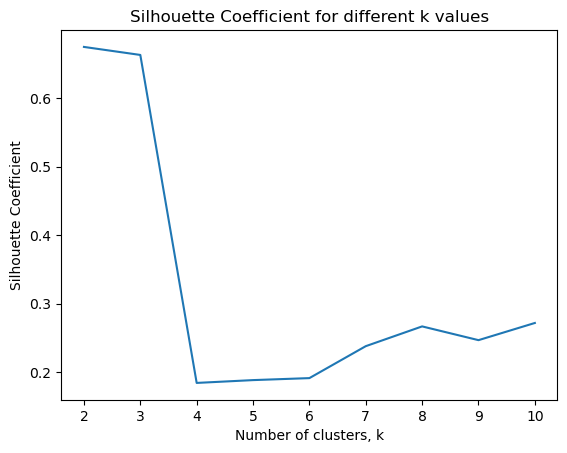

In [116]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of possible k values
possible_k_values = range(2, 11)
errors_per_k = []

# Calculate silhouette score for each k
for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(customer_data_preprocessed)
    silhouette_avg = silhouette_score(customer_data_preprocessed, labels)
    errors_per_k.append(silhouette_avg)

# Plot the silhouette coefficients
fig = plt.figure()
ax = plt.axes()
ax.plot(possible_k_values, errors_per_k)
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient for different k values')
plt.show()

# Apply K-means clustering with the best k
final_kmeans = KMeans(n_clusters=3, n_init = 10, random_state=42)
customer_data['cluster'] = final_kmeans.fit_predict(customer_data_preprocessed)


There is a drop in Silhouette Coefficient for k above 3. Based on this plot we might choose a value for k = 3. 

let's take best_k = 2 


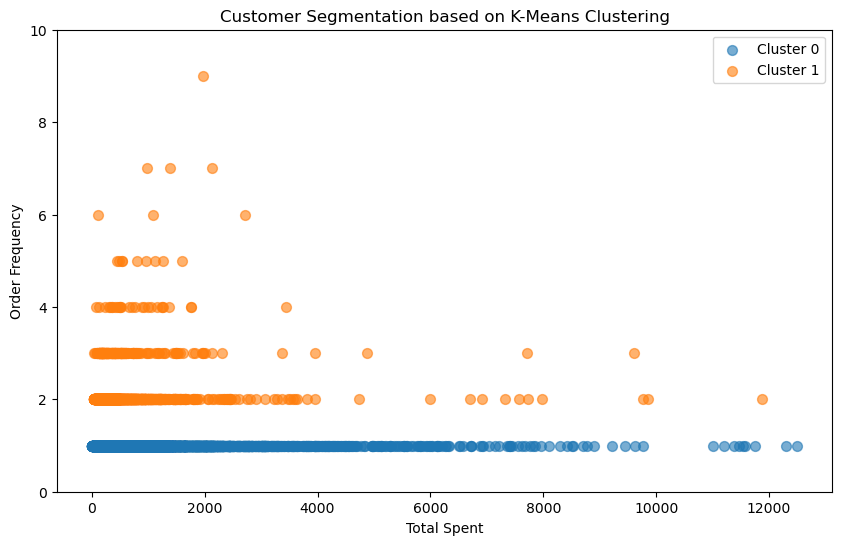

In [134]:
best_k = 2

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
for cluster in range(best_k):
    cluster_data = customer_data[customer_data['cluster'] == cluster]
    plt.scatter(cluster_data['total_spent'], cluster_data['order_frequency'], label=f'Cluster {cluster}', s=50, alpha=0.6)


plt.title('Customer Segmentation based on K-Means Clustering')
plt.xlabel('Total Spent')
plt.ylabel('Order Frequency')
plt.ylim(0, 10)    
plt.legend()
plt.show()



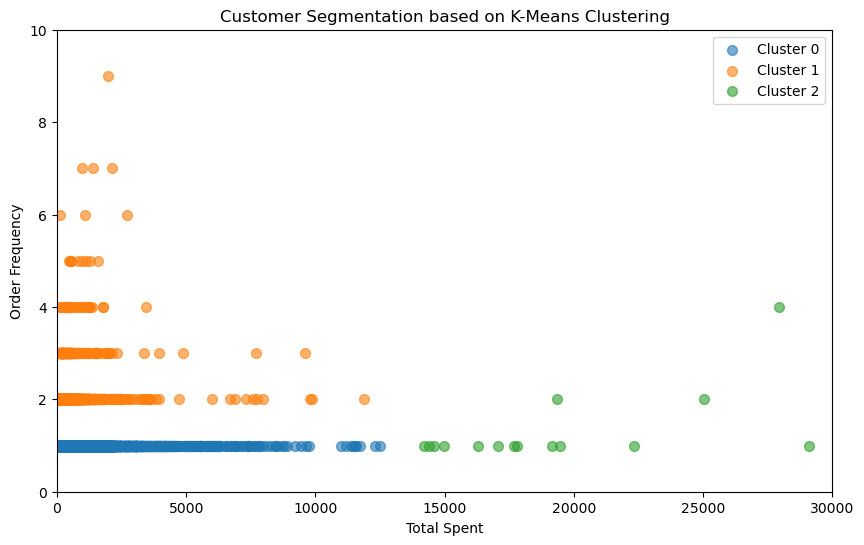

In [135]:
best_k = 3

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
for cluster in range(best_k):
    cluster_data = customer_data[customer_data['cluster'] == cluster]
    plt.scatter(cluster_data['total_spent'], cluster_data['order_frequency'], label=f'Cluster {cluster}', s=50, alpha=0.6)

plt.title('Customer Segmentation based on K-Means Clustering')
plt.xlabel('Total Spent')
plt.ylabel('Order Frequency')

plt.xlim(0, 30000)  
plt.ylim(0, 10)    

plt.legend()
plt.show()

After comparing the graphs for both k=2 and k=3, we can conclude that k=3 would be the best choice for clustering to achieve better performance of the model.



### Product Recommendation

Using the clusters identified, we recommended products to customers based on the popular products within their cluster.



In [130]:

# Recommending products based on clusters
def recommend_products_for_customer(customer_id, num_recommendations=5):
    # Get customer unique ID
    customer_unique_id = customers[customers['customer_id'] == customer_id]['customer_unique_id'].values[0]
    
    # Find the cluster for this customer
    customer_cluster = customer_data[customer_data['customer_unique_id'] == customer_unique_id]['cluster'].values[0]
    
    # Get customer IDs in the same cluster
    cluster_customers = customer_data[customer_data['cluster'] == customer_cluster]['customer_unique_id']
    
    # Find popular products among customers in this cluster
    popular_products = merged_data[merged_data['customer_unique_id'].isin(cluster_customers)]
    popular_products = popular_products.groupby(['product_id', 'product category']).size().sort_values(ascending=False)
    
    # Get top recommended products
    top_products = popular_products.head(num_recommendations).index.tolist()
    
    # Retrieve product names
    recommended_product_names = []
    for product_id, product_category in top_products:
        product_name = merged_data[merged_data['product_id'] == product_id]['product category'].values[0]
        recommended_product_names.append(product_name)
    
    return recommended_product_names

# Testing the model with a random customer ID
customer_id_to_recommend = '5aa9e4fdd4dfd20959cad2d772509598'  
recommended_products = recommend_products_for_customer(customer_id_to_recommend)
print(f"Recommended products for customer {customer_id_to_recommend}: {recommended_products}")

Recommended products for customer 5aa9e4fdd4dfd20959cad2d772509598: ['Furniture Decoration', 'bed table bath', 'Garden tools', 'Garden tools', 'Garden tools']


As per the output 'Furniture Decoration', 'bed table bath', 'Garden tools', 'Garden tools', 'Garden tools', the top 5 recommended product categories for the customer with ID '5aa9e4fdd4dfd20959cad2d772509598' based on the purchasing behavior of customers in the same cluster. These recommendations are derived from the clustering analysis, suggesting that customers in this cluster commonly purchase items from these categories.


In [131]:
# Testing the model with a random customer ID
customer_id_to_recommend = '1617b1357756262bfa56ab541c47bc16'  
recommended_products = recommend_products_for_customer(customer_id_to_recommend)
print(f"Recommended products for customer {customer_id_to_recommend}: {recommended_products}")

Recommended products for customer 1617b1357756262bfa56ab541c47bc16: ['telephony', 'automotive', 'computer accessories', 'Furniture Decoration', 'Garden tools']


In [132]:
# Testing the model with a random customer ID
customer_id_to_recommend = '3f6ede29d4c69cd3316d2035b6cec1fb'  
recommended_products = recommend_products_for_customer(customer_id_to_recommend)
print(f"Recommended products for customer {customer_id_to_recommend}: {recommended_products}")

Recommended products for customer 3f6ede29d4c69cd3316d2035b6cec1fb: ['HEALTH BEAUTY', 'bed table bath', 'Garden tools', 'computer accessories', 'bed table bath']


The recommended products ('HEALTH BEAUTY', 'bed table bath', 'Garden tools', 'computer accessories', 'bed table bath') are those that are popular or frequently purchased by the customer (customer_id: '3f6ede29d4c69cd3316d2035b6cec1fb') in terms of their purchasing behavior.


Let's see all custers

In [133]:
customer_data[customer_data['cluster']==0].head()

,customer_unique_id,total_spent,order_frequency,customer_city,customer_state,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,cajamar,SP,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,osasco,SP,0
2,0000f46a3911fa3c0805444483337064,86.22,1,sao jose,SC,0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,belem,PA,0
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,sorocaba,SP,0


In [83]:
customer_data[customer_data['cluster']==1].head()

,customer_unique_id,total_spent,order_frequency,customer_city,customer_state,cluster
103,004288347e5e88a27ded2bb23747066c,354.37,2,nova iguacu,RJ,1
241,00a39521eb40f7012db50455bf083460,123.25,2,brasilia,DF,1
303,00cc12a6d8b578b8ebd21ea4e2ae8b27,126.20,2,sao paulo,SP,1
401,011575986092c30523ecb71ff10cb473,214.90,2,belo horizonte,MG,1
416,011b4adcd54683b480c4d841250a987f,386.18,2,santo amaro,BA,1


In [81]:
customer_data[customer_data['cluster']==2].head()

,customer_unique_id,total_spent,order_frequency,customer_city,customer_state,cluster
3676,0a0a92112bd4c708ca5fde585afaa872,109312.64,1,rio de janeiro,RJ,2
5554,0f5ac8d5c31de21d2f25e24be15bbffb,19342.26,2,uniao da vitoria,PR,2
9949,1b76903617af13189607a36b0469f6f3,19174.38,1,sao luis,MA,2
11798,20a5257c01689ac69410a14cb51bb447,17671.00,1,diadema,SP,2
18010,31e412b9fb766b6794724ed17a41dfa6,14196.28,1,santos,SP,2


### Delivery Time Prediction

We used a Decision Tree Classifier to predict whether an order would be delivered early based on various features.

Let's employs feature engineering to derive meaningful predictors (delivery_time, early_delivery), then we will preprocesses the data to handle numerical and categorical variables appropriately. 


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Feature Engineering
# Create a feature 'delivery_time' which is the difference between the estimated delivery date and the actual delivery date
merged_data['order_estimated_delivery_date'] = pd.to_datetime(merged_data['order_estimated_delivery_date'])
merged_data['order_delivered_customer_date'] = pd.to_datetime(merged_data['order_delivered_customer_date'])
merged_data['delivery_time'] = (merged_data['order_estimated_delivery_date'] - merged_data['order_delivered_customer_date']).dt.days

# Create the target variable 'early_delivery' (1 if the product was delivered early, 0 otherwise)
merged_data['early_delivery'] = (merged_data['delivery_time'] > 0).astype(int)

merged_data.dropna(inplace = True)

# Select features for the model
# Adding categorical features such as payment_type, customer_city, and customer_state
features = ['price', 'freight_value', 'payment_value', 'product_name_length', 
            'product_description_length', 'product_photos_qty', 'product_weight_g', 
            'product_length_cm', 'product_height_cm', 'product_width_cm',
            'payment_type', 'customer_city', 'customer_state']

X = merged_data[features]
y = merged_data['early_delivery']

# Preprocessing
# Identify categorical and numerical features
categorical_features = ['payment_type', 'customer_city', 'customer_state']
numerical_features = ['price', 'freight_value', 'payment_value', 'product_name_length', 
                      'product_description_length', 'product_photos_qty', 'product_weight_g', 
                      'product_length_cm', 'product_height_cm', 'product_width_cm']

# Preprocessing pipelines for both numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')



Now, let's build a predictive model using a decision tree classifier, and evaluates its performance in predicting early deliveries based on the chosen features. This approach aims to enhance logistics and operational efficiency by predicting delivery timeliness.

In [30]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build and train the model
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8601875532821824
Confusion Matrix:
 [[  856  2329]
 [ 2427 28405]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.27      0.26      3185
           1       0.92      0.92      0.92     30832

    accuracy                           0.86     34017
   macro avg       0.59      0.60      0.59     34017
weighted avg       0.86      0.86      0.86     34017



As per the output, the model achieves an accuracy of approximately 86%. It correctly predicts 28% of early deliveries (class 0) and 92% of non-early deliveries (class 1). The precision, recall, and F1-score for both classes indicate a strong performance in predicting non-early deliveries, with weaker performance on early deliveries due to lower recall.


In [31]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Apply k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

print("Cross-Validation Scores: ", cv_results)
print("Mean Cross-Validation Score: ", np.mean(cv_results))

Cross-Validation Scores:  [0.8626863  0.86312726 0.86542023 0.86449422 0.86092248]
Mean Cross-Validation Score:  0.8633300996560542


The cross-validation process yields scores of approximately 86.41%, 86.31%, 86.18%, 86.25%, and 86.49% across five folds. The mean cross-validation score, calculated as the average of these scores, is approximately 86.33%. This indicates a consistent and robust performance of the model across different subsets of the data during validation.


### Results

The clustering analysis determined the optimal number of clusters (k=3) based on silhouette scores. Product recommendations were made based on cluster popularity, providing personalized suggestions for customers.

The Decision Tree model achieved an accuracy of 86.16% in predicting early deliveries, with a precision of 0.92 for on-time deliveries. The model was evaluated using cross-validation to ensure robustness, achieving a mean cross-validation score of 86.33%.



## Conclusion

#### Insights and Recommendations
- Customer Segmentation: The clustering analysis provides clear insights into customer segments based on purchasing behavior. These segments can guide targeted marketing strategies and personalized promotions to improve customer engagement and retention.

- Product Recommendations: Leveraging the clustering results, ongoing efforts can be made to refine and optimize product recommendations further. This could involve integrating real-time data and feedback to continuously enhance the relevance and effectiveness of recommendations.

- Operational Efficiency: The predictive model for delivery times offers significant potential in optimizing logistics and resource allocation. By accurately predicting delivery times, businesses can streamline operations, reduce costs, and enhance overall service levels.


In conclusion, the analysis and modeling efforts presented in the report provide actionable insights for improving customer experience, optimizing operations, and driving business growth in e-commerce. By understanding customer preferences, predicting delivery times, and offering personalized recommendations, businesses can foster stronger customer relationships and competitive advantage in the market.